In [ ]:
import torch
print(torch.__version__)

1.9.0+cu102


In [ ]:
import platform
print(platform.python_version())

3.7.11


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Data prepration

In [ ]:
import pickle
import time
import numpy
import theano
from theano import sandbox
import theano.tensor as tensor
import os
import scipy.io
from collections import defaultdict
import numpy as np
import pandas as pd

d = pd.read_csv('/content/drive/MyDrive/Thesisdata/mydata/CDS.csv')
d.iloc[:,1:]

,date,UK,Greece,Belgium,Germany,France,Italy,Portugal,Spain,Denmark,Sweden
0,2008-11-03,110.000,131.00,55.00,100.00,40.00,113.0000,84.00,87.0000,61.00,64.00000
1,2008-11-04,110.000,125.00,53.00,100.00,39.00,105.0000,73.00,75.0000,66.00,66.00000
2,2008-11-05,110.000,125.00,53.00,100.00,39.00,105.0000,73.00,75.0000,66.00,66.00000
3,2008-11-06,125.875,125.00,52.00,106.00,39.00,103.0000,73.00,74.0000,65.00,66.00000
4,2008-11-07,130.875,125.00,52.00,110.00,39.00,103.0000,73.00,74.0000,66.00,66.00000
...,...,...,...,...,...,...,...,...,...,...,...
863,2012-02-23,181.520,17793.18,245.38,175.29,186.18,392.3799,1183.91,372.6399,122.52,53.25999
864,2012-02-24,173.090,17879.50,241.90,175.29,180.26,387.3699,1175.99,366.1599,120.52,52.78000
865,2012-02-27,174.140,20940.19,242.83,175.31,180.24,390.1399,1176.75,370.4299,120.52,52.31000
866,2012-02-28,167.620,22340.21,238.57,172.88,176.46,381.0298,1171.43,364.1299,117.17,51.81999


In [ ]:
d.iloc[600,1]

'2011-02-21'

In [ ]:
#Missing values
d.isna().sum().sum()


0

In [ ]:
from datetime import datetime
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)
    
#days_between(d.iloc[0,1],d.iloc[10,1])

a = numpy.zeros(shape=(868,10))
df = pd.DataFrame(a,columns=d.columns[2:])
for i in range(10):
  for j in range(868):
    if d.iloc[j,i+2] > d.iloc[:,i+2].quantile(0.9) or  d.iloc[j,i+2] < d.iloc[:,i+2].quantile(0.1):
      df.iloc[j,i]=d.iloc[j,i+2]
df


,UK,Greece,Belgium,Germany,France,Italy,Portugal,Spain,Denmark,Sweden
0,0.0,131.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0
1,0.0,125.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0
2,0.0,125.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0
3,0.0,125.00,0.0,0.0,0.00,0.0,0.00,74.0,0.0,0.0
4,0.0,125.00,0.0,0.0,0.00,0.0,0.00,74.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
863,0.0,17793.18,0.0,0.0,186.18,0.0,1183.91,0.0,0.0,0.0
864,0.0,17879.50,0.0,0.0,180.26,0.0,1175.99,0.0,0.0,0.0
865,0.0,20940.19,0.0,0.0,180.24,0.0,1176.75,0.0,0.0,0.0
866,0.0,22340.21,0.0,0.0,0.00,0.0,1171.43,0.0,0.0,0.0


In [ ]:
type(d.date)

pandas.core.series.Series

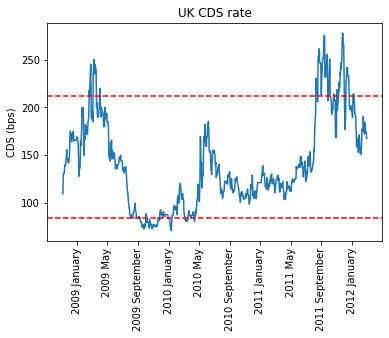

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
dmo = pd.DataFrame(d["UK"].values, index=pd.to_datetime(d.date))

fig,ax1 = plt.subplots()
plt.plot(dmo.index,dmo.values)
monthyearFmt = mdates.DateFormatter('%Y %B')
ax1.xaxis.set_major_formatter(monthyearFmt)

_ = plt.xticks(rotation=90)

plt.axhline(y=d.UK.quantile(0.1), color='r', linestyle='--')
plt.axhline(y=d.UK.quantile(0.9), color='r', linestyle='--')
plt.ylabel("CDS (bps)")
plt.title("UK CDS rate")

plt.show()

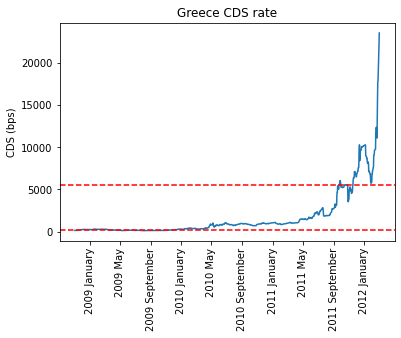

In [ ]:

dmo = pd.DataFrame(d["Greece"].values, index=pd.to_datetime(d.date))

fig,ax1 = plt.subplots()
plt.plot(dmo.index,dmo.values)
monthyearFmt = mdates.DateFormatter('%Y %B')
ax1.xaxis.set_major_formatter(monthyearFmt)

_ = plt.xticks(rotation=90)

plt.axhline(y=d.Greece.quantile(0.1), color='r', linestyle='--')
plt.axhline(y=d.Greece.quantile(0.9), color='r', linestyle='--')
plt.ylabel("CDS (bps)")
plt.title("Greece CDS rate")

plt.show()

<Figure size 1080x1080 with 0 Axes>

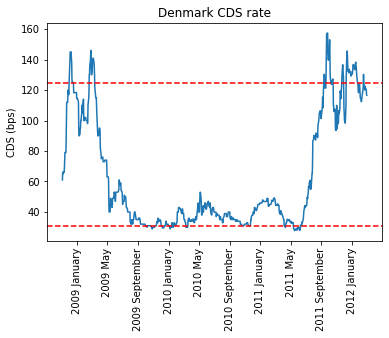

In [ ]:
plt.figure(figsize=(15,15))

dmo = pd.DataFrame(d["Denmark"].values, index=pd.to_datetime(d.date))

fig,ax1 = plt.subplots()
plt.plot(dmo.index,dmo.values)
monthyearFmt = mdates.DateFormatter('%Y %B')
ax1.xaxis.set_major_formatter(monthyearFmt)

_ = plt.xticks(rotation=90)

plt.axhline(y=d.Denmark.quantile(0.1), color='r', linestyle='--')
plt.axhline(y=d.Denmark.quantile(0.9), color='r', linestyle='--')
plt.ylabel("CDS (bps)")
plt.title("Denmark CDS rate")

plt.show()

In [ ]:
UK=[]

for i in range(df.shape[0]):      
    if df.iloc[i,0]>0:
        time_since_start=days_between(d.iloc[0,1],d.iloc[i,1])
        UK.append(time_since_start)

GC=[]

for i in range(df.shape[0]):      
    if df.iloc[i,1]>0:
        time_since_start=days_between(d.iloc[0,1],d.iloc[i,1])
        GC.append(time_since_start)

Fr=[]

for i in range(df.shape[0]):      
    if df.iloc[i,8]>0:
        time_since_start=days_between(d.iloc[0,1],d.iloc[i,1])
        Fr.append(time_since_start)

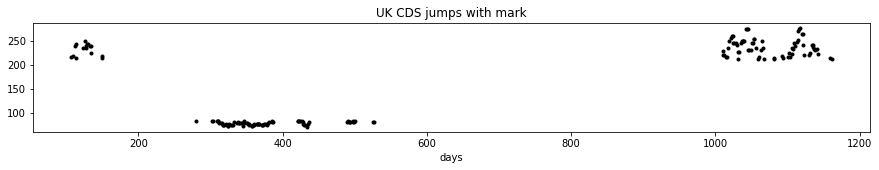

In [ ]:
ar=np.array(UK)
plt.figure(figsize=(15,2))
plt.title("UK CDS jumps with mark")
plt.xlabel("days")
_ = plt.plot(UK, df.UK[df.UK !=0], 'k.');

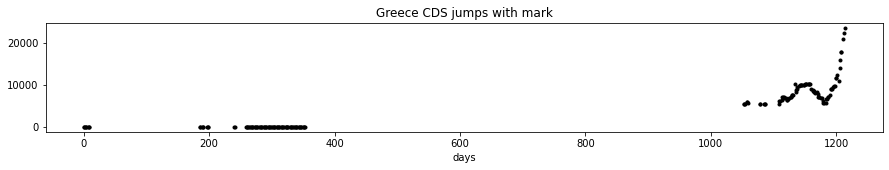

In [ ]:
ar=np.array(GC)

plt.figure(figsize=(15,2))
plt.title("Greece CDS jumps with mark")
plt.xlabel("days")
_ = plt.plot(GC, df.Greece[df.Greece !=0], 'k.');

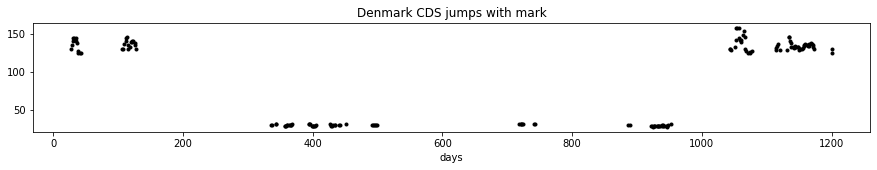

In [ ]:
ar=np.array(Fr)

plt.figure(figsize=(15,2))
plt.title("Denmark CDS jumps with mark")
plt.xlabel("days")
_ = plt.plot(Fr, df.Denmark[df.Denmark !=0], 'k.');

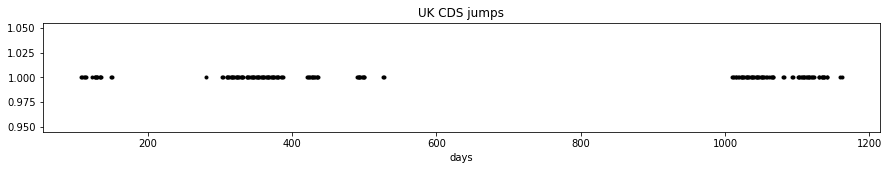

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt
ar=np.array(UK)
plt.figure(figsize=(15,2))
plt.title("UK CDS jumps")
plt.xlabel("days")
_ = plt.plot(UK, np.ones_like(UK), 'k.');


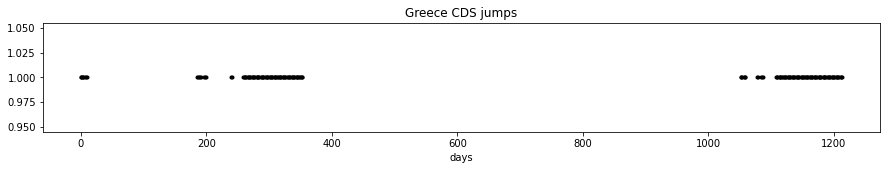

In [ ]:
plt.figure(figsize=(15,2))
plt.title("Greece CDS jumps")
plt.xlabel("days")
_ = plt.plot(GC, np.ones_like(GC), 'k.');


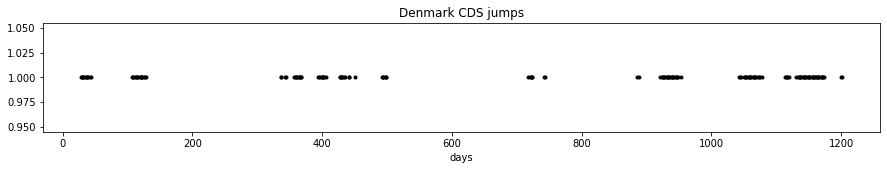

In [ ]:
plt.figure(figsize=(15,2))
plt.title("Denmark CDS jumps")
plt.xlabel("days")
_ = plt.plot(Fr, np.ones_like(Fr), 'k.');

In [ ]:
d.date[d.index==800]

800    2011-11-28
Name: date, dtype: object

In [ ]:

dim_process = 10
args=[]
devtest=[]
dev=[]
traindata = {
     'dim_process':[],
     'devtest':[],
     'args':[],
     'dev':[],
     'train':[[]],
     'test':[]}
testdata = {
     'dim_process':[],
     'devtest':[],
     'args':[],
     'dev':[],
     'train':[],
     'test':[[]]}

k=0.01
dt=0

time_since_start=0
for t in range(1):
  for j in range(df.shape[1]):
    time_since_last_event=0
    temp=0
    m=0
    for i in range(df.shape[0]):      
       if df.iloc[i,j]>0:
          if m ==0:
            time_since_start=days_between(d.iloc[0,1],d.iloc[i,1])+dt
            time_since_last_event=0
            temp=time_since_start

            traindata["dim_process"]=dim_process
            traindata["dev"]=dev
            traindata["args"]=args
            traindata["test"]=[]
            traindata["devtest"]=devtest
            traindata["train"][t].append({
                  "time_since_last_event" : time_since_last_event,
                  "time_since_start":time_since_start,
                  "type_event":j,
                  "xy":df.iloc[i,j]})
          elif i < 700:
            time_since_start=days_between(d.iloc[0,1],d.iloc[i,1])+dt
            time_since_last_event=time_since_start-temp
            temp=time_since_start
          
            traindata["dim_process"]=dim_process
            traindata["dev"]=dev
            traindata["args"]=args
            traindata["test"]=[]
            traindata["devtest"]=devtest
            traindata["train"][t].append({
                  "time_since_last_event" : time_since_last_event,
                  "time_since_start":time_since_start,
                  "type_event":j,
                  "xy":df.iloc[i,j]})
          elif i >= 700:
            time_since_start=days_between(d.iloc[0,1],d.iloc[i,1])+dt
            time_since_last_event=time_since_start-temp
            temp=time_since_start
          
            testdata["dim_process"]=dim_process
            testdata["dev"]=dev
            testdata["args"]=args
            testdata["train"]=[]
            testdata["devtest"]=devtest
            testdata["test"][t].append({
                  "time_since_last_event" : time_since_last_event,
                  "time_since_start":time_since_start,
                  "type_event":j,
                  "xy":df.iloc[i,j]})
          m+=1
        
    dt=k+dt

In [ ]:
testdata["test"][0]= sorted(testdata["test"][0], key = lambda i: i['time_since_start'])
traindata["train"][0]= sorted(traindata["train"][0], key = lambda i: i['time_since_start'])

In [ ]:
file_save = '/content/drive/MyDrive/Thesisdata/mydata/'+"train"+'.pkl'
file_save = os.path.abspath(file_save)
print ("saving ... ")
with open(file_save, 'wb') as f:
        pickle.dump(traindata, f)
file_save = '/content/drive/MyDrive/Thesisdata/mydata/'+"test"+'.pkl'
file_save = os.path.abspath(file_save)
print ("saving ... ")
with open(file_save, 'wb') as f:
        pickle.dump(testdata, f)

saving ... 
saving ... 


In [ ]:
traindata

{'args': [],
 'dev': [],
 'devtest': [],
 'dim_process': 10,
 'test': [],
 'train': [[{'time_since_last_event': 0,
    'time_since_start': 0.01,
    'type_event': 1,
    'xy': 131.0},
   {'time_since_last_event': 1.0,
    'time_since_start': 1.01,
    'type_event': 1,
    'xy': 125.0},
   {'time_since_last_event': 0.9999999999999998,
    'time_since_start': 2.01,
    'type_event': 1,
    'xy': 125.0},
   {'time_since_last_event': 1.0,
    'time_since_start': 3.01,
    'type_event': 1,
    'xy': 125.0},
   {'time_since_last_event': 0,
    'time_since_start': 3.07,
    'type_event': 7,
    'xy': 74.0},
   {'time_since_last_event': 1.0,
    'time_since_start': 4.01,
    'type_event': 1,
    'xy': 125.0},
   {'time_since_last_event': 1.0000000000000004,
    'time_since_start': 4.07,
    'type_event': 7,
    'xy': 74.0},
   {'time_since_last_event': 3.0,
    'time_since_start': 7.01,
    'type_event': 1,
    'xy': 125.0},
   {'time_since_last_event': 3.0,
    'time_since_start': 7.07,
    '

# Transformer Hawkes Process

In [ ]:
!bash /content/drive/MyDrive/CodesandData/run.sh

[Info] parameters: Namespace(batch_size=4, d_inner_hid=1024, d_k=512, d_model=512, d_rnn=64, d_v=512, data='/content/drive/MyDrive/Thesisdata/mydata/', device=device(type='cuda'), dropout=0.1, epoch=100, log='/content/drive/MyDrive/Thesisdata/mydata/log0.txt', lr=0.0001, n_head=4, n_layers=4, smooth=0.1)
[Info] Loading train data...
[Info] Loading dev data...
[Info] Loading test data...
[Info] Number of parameters: 21185548
[ Epoch 1 ]
  - (Training)    loglikelihood: -0.93064, accuracy:  0.10503, RMSE:  6.49688, elapse: 0.004 min
  - (Testing)     loglikelihood: -0.55336, accuracy:  0.10000, RMSE:  0.65483, elapse: 0.002 min
  - [Info] Maximum ll: -0.55336, Maximum accuracy:  0.10000, Minimum RMSE:  0.65483
[ Epoch 2 ]
  - (Training)    loglikelihood: -0.88531, accuracy:  0.16579, RMSE:  6.48354, elapse: 0.004 min
  - (Testing)     loglikelihood: -0.53425, accuracy:  0.10270, RMSE:  0.67171, elapse: 0.002 min
  - [Info] Maximum ll: -0.53425, Maximum accuracy:  0.10270, Minimum RMSE:  

# Temporal and Significant Transformer Hawkes Process

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

#Just new encoder (-334 spatial)
#2
!bash /content/drive/MyDrive/Thesisdata/run.sh

[Info] parameters: Namespace(batch_size=1, d_inner_hid=1024, d_k=512, d_model=512, d_v=512, data='/content/drive/MyDrive/Thesisdata/mydata/', device=device(type='cuda'), dropout=0.1, epoch=100, log='/content/drive/MyDrive/Thesisdata/mydata/log.txt', lr=0.0001, n_head=6, n_layers=4, smooth=0.1)
[Info] Loading train data   ...
[Info] Loading test data...
[Info] Number of parameters: 29917708
[ Epoch 1 ]
  - (Training)    loglikelihood: -0.99510, accuracy:  0.10878, RMSE:  6.67547, elapse: 0.005 min
  - (Testing)     loglikelihood: -0.34524, accuracy:  0.10541, RMSE:  1.10487, elapse: 0.002 min
  - [Info] Maximum ll: -0.34524, Maximum accuracy:  0.10541, Minimum RMSE:  1.10487
[ Epoch 2 ]
  - (Training)    loglikelihood: -0.80433, accuracy:  0.14779, RMSE:  6.61998, elapse: 0.005 min
  - (Testing)     loglikelihood: -0.17887, accuracy:  0.11351, RMSE:  1.21402, elapse: 0.002 min
  - [Info] Maximum ll: -0.17887, Maximum accuracy:  0.11351, Minimum RMSE:  1.10487
[ Epoch 3 ]
  - (Training) 

In [ ]:
"""
import torch, gc
gc.collect()
torch.cuda.empty_cache()

#Just new encoder (-116 spatial)
!bash /content/drive/MyDrive/Thesisdata/run.sh
"""

# Transformer and Hopfield Hawkes Process


Data from previous part


In [ ]:
import os
import pickle
import time
def load_data(name):
    data = torch.load(name,map_location=torch.device('cpu'))
    return data
data= "/content/drive/MyDrive/Thesisdata/"
print('[Info] Loading decoder train data...')
event_type_pred1=load_data(data + 'event_type_ptrain.pt')
#event_type_pred1=torch.max(event_type_pred1, dim=-1)[1].tolist()
event_time_pred1=load_data(data + 'event_time_pred1.pt').tolist()
xy_pred1=load_data(data + 'xy_pred1.pt').tolist()

print('[Info] Loading decoder test data...')
event_type_pred2=load_data(data + 'event_type_ptest.pt')
#event_type_pred2=torch.max(event_type_pred2, dim=-1)[1].tolist()
event_time_pred2=load_data(data + 'event_time_pred2.pt').tolist()
xy_pred2=load_data(data + 'xy_pred2.pt').tolist()

dim_process = 10
args=[]
devtest=[]
dev=[]
traindata = {
     'dim_process':[],
     'devtest':[],
     'args':[],
     'dev':[],
     'train':[[]],
     'test':[]}
testdata = {
     'dim_process':[],
     'devtest':[],
     'args':[],
     'dev':[],
     'train':[],
     'test':[[]]}
for t in range(1):
    for j in range(len(event_time_pred1[0])): 
      if j == len(event_time_pred1[0])-1:
          time_since_start=event_time_pred1[t][j]
          time_since_last_event=event_time_pred1[t][j]
          traindata["dim_process"]=dim_process
          traindata["dev"]=dev
          traindata["args"]=args
          traindata["test"]=[]
          traindata["devtest"]=devtest
          traindata["train"][t].append({
                "time_since_last_event" : time_since_last_event,
                "time_since_start":time_since_start,
                "type_event":event_type_pred1[t][j],
                "xy":xy_pred1[t][j]})
      else:
          time_since_start=event_time_pred1[t][j+1]-event_time_pred1[t][j]
          time_since_last_event=event_time_pred1[t][j+1]-event_time_pred1[t][j]
          traindata["dim_process"]=dim_process
          traindata["dev"]=dev
          traindata["args"]=args
          traindata["test"]=[]
          traindata["devtest"]=devtest
          traindata["train"][t].append({
                "time_since_last_event" : time_since_last_event,
                "time_since_start":time_since_start,
                "type_event":event_type_pred1[t][j-1],
                "xy":xy_pred1[t][j]})        
      

for t in range(1):
    for j in range(len(event_time_pred2[0])): 
       if j == len(event_time_pred2[0])-1:
            time_since_last_event=event_time_pred2[t][j]
            time_since_start=event_time_pred2[t][j]
            testdata["dim_process"]=dim_process
            testdata["dev"]=dev
            testdata["args"]=args
            testdata["train"]=[]
            testdata["devtest"]=devtest
            testdata["test"][t].append({
                  "time_since_last_event" : time_since_last_event,
                  "time_since_start":time_since_start,
                  "type_event":event_type_pred2[t][j],
                  "xy":xy_pred2[t][j]})
       else:
            time_since_last_event=event_time_pred2[t][j+1]-event_time_pred2[t][j]
            time_since_start=event_time_pred2[t][j+1]-event_time_pred2[t][j]
            testdata["dim_process"]=dim_process
            testdata["dev"]=dev
            testdata["args"]=args
            testdata["train"]=[]
            testdata["devtest"]=devtest
            testdata["test"][t].append({
                  "time_since_last_event" : time_since_last_event,
                  "time_since_start":time_since_start,
                  "type_event":event_type_pred2[t][j-1],
                  "xy":xy_pred2[t][j]})

file_save = '/content/drive/MyDrive/Thesisdata/mydata/'+"train_pred"+'.pkl'
file_save = os.path.abspath(file_save)
print ("saving ... ")
with open(file_save, 'wb') as f:
        pickle.dump(traindata, f)
file_save = '/content/drive/MyDrive/Thesisdata/mydata/'+"test_pred"+'.pkl'
file_save = os.path.abspath(file_save)
print ("saving ... ")
with open(file_save, 'wb') as f:
        pickle.dump(testdata, f)

[Info] Loading decoder train data...
[Info] Loading decoder test data...
saving ... 
saving ... 


In [ ]:
event_type_pred2

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 5, 2, 4, 4, 5, 2, 3, 4, 5, 6,
         1, 2, 4, 4, 5, 6, 7, 8, 5, 2, 3, 4, 5, 6, 7, 0, 0, 1, 2, 3, 4, 5, 6, 7,
         0, 0, 1, 2, 3, 4, 5, 6, 7, 0, 0, 1, 2, 3, 4, 5, 6, 7, 6, 0, 1, 1, 3, 4,
         5, 6, 7, 8, 0, 1, 1, 3, 4, 5, 6, 7, 0, 0, 1, 1, 3, 4, 5, 6, 7, 0, 0, 2,
         3, 3, 4, 5, 6, 7, 6, 0, 3, 3, 4, 5, 6, 7, 0, 0, 3, 3, 4, 5, 6, 7, 0, 0,
         3, 3, 4, 5, 6, 7, 8, 0, 1, 3, 4, 5, 6, 7, 8, 0, 1, 3, 4, 5, 6, 7, 8, 0,
         1, 3, 4, 5, 6, 7, 1, 0, 1, 3, 4, 5, 6, 7, 1, 0, 2, 3, 4, 5, 6, 0, 2, 4,
         4, 5, 6, 0, 1, 4, 4, 5, 6, 0, 0, 1, 4, 4, 5, 6, 7, 8, 0, 1, 4, 4, 5, 7,
         7, 6, 0, 1, 1, 4, 4, 5, 6, 7, 6, 0, 1, 1, 3, 4, 5, 7, 7, 8, 1, 1, 4, 4,
         5, 1, 7, 1, 1, 1, 4, 4, 5, 6, 1, 1, 1, 4, 4, 5, 6, 8, 1, 1, 4, 4, 5, 6,
         7, 1, 1, 1, 4, 4, 5, 1, 7, 1, 1, 1, 4, 4, 5, 6, 7, 1, 1, 2, 4, 4, 5, 6,
         1, 1, 1, 1, 1, 4, 5

In [ ]:
!pip install bertviz

In [ ]:
import torch
print('[Info] attention matrices...')
data= "/content/drive/MyDrive/Thesisdata/mydata/attn/"

attntrain1=load_data(data + 'attn.train1.pt')
attntrain2=load_data(data + 'attn.train2.pt')
attntrain3=load_data(data + 'attn.train3.pt')
attntrain4=load_data(data + 'attn.train4.pt')
attntrain5=load_data(data + 'attn.train5.pt')
attntrain6=load_data(data + 'attn.train6.pt')
attntrain7=load_data(data + 'attn.train7.pt')
attntrain=load_data(data + 'attn.train.pt')
#attntest=load_data(data + 'attn.test.pt')
type1=load_data(data + 'event_type1.pt')
type2=load_data(data + 'event_type2.pt')
type3=load_data(data + 'event_type3.pt')
type4=load_data(data + 'event_type4.pt')
type5=load_data(data + 'event_type5.pt')
type6=load_data(data + 'event_type6.pt')
type7=load_data(data + 'event_type7.pt')
typetrain=load_data(data + 'event_type.pt')
enc1=load_data(data + 'encout.train1.pt')
enc2=load_data(data + 'encout.train2.pt')
enc3=load_data(data + 'encout.train3.pt')
enc4=load_data(data + 'encout.train4.pt')
enc5=load_data(data + 'encout.train5.pt')
enc6=load_data(data + 'encout.train6.pt')
enc7=load_data(data + 'encout.train7.pt')
enc8=load_data(data + 'encout.train.pt')


[Info] attention matrices...


In [ ]:
attntrain.shape

torch.Size([1, 6, 1334, 1334])

In [ ]:
type4.shape

torch.Size([1, 652])

In [ ]:
import pandas as  pd
typ=type7[:,-166:]
att=attntrain7[:,:,-166:,-166:]
attnx=torch.rand(0,10,10)
for i in range(len(att[0])):
    x=att[0][i]
    px = pd.DataFrame(x).astype("float")
    px['new']=pd.DataFrame(typ[0]).astype("float")
    pxx=px.groupby('new', sort=True, as_index=False).sum()
    pxx.set_index('new', inplace=True)
    #pxx = (pxx - np.mean(pxx)) / np.std(pxx) 
    pxx=pxx.T
    pxx['new']=pd.DataFrame(typ[0]).astype("float")
    pxx=pxx.groupby('new', sort=True, as_index=False).sum()
    pxx.set_index('new', inplace=True)

    dxx= pd.DataFrame(0, index=np.arange(11), columns=np.arange(11))
    dxx.drop(0,axis=1, inplace=True)
    dxx.drop(0,axis=0, inplace=True)
    for i in range(11):
      for j in range(11):
        if i in pxx.index:
          if j in pxx.index:
             dxx.iloc[i-1,j-1]=pxx.loc[i,j]
    #pxx=pxx.drop(columns=['new'])


    pxx_tensor  = torch.tensor(dxx.values)
    pxx_tensor = pxx_tensor.unsqueeze(0)
    attnx=torch.cat((attnx,pxx_tensor), dim=0)
attnx=attnx.unsqueeze(0)
attnx=attnx.unsqueeze(0)
import numpy as np
col={1:"UK",2:"Greece",3:"Belgium",4:"Germany",5:"France",6:"Italy",7:"Portugal",8:"Spain",9:"Denmark",10:"Sweden"}
tt=[]
for i in range(10):
    tt.append(col[i+1])
opt =["%s" % i for i in tt]


In [ ]:
from bertviz import head_view
head_view(encoder_attention=attnx,encoder_tokens= opt)

<IPython.core.display.Javascript object>

In [ ]:
dxx

,1,2,3,4,5,6,7,8,9,10
1,0.180115,0.049340,0.197913,0.120407,0.158762,0.109069,0.027345,0.109544,0.039564,0
2,0.132015,0.095925,0.235934,0.059151,0.104514,0.223330,0.036080,0.188976,0.039254,0
3,0.387074,0.088838,0.590131,0.357194,0.387668,0.168835,0.027293,0.204008,0.050054,0
4,0.221213,0.062466,0.233530,0.212744,0.229352,0.136233,0.027088,0.135781,0.027545,0
5,0.585632,0.112951,0.787801,0.408358,0.797059,0.197646,0.049782,0.183920,0.091330,0
6,0.376675,0.248876,0.575202,0.285561,0.221282,0.254990,0.040381,0.328669,0.057212,0
7,0.129580,0.189100,0.395038,0.179077,0.204003,0.396877,0.095119,0.549120,0.034392,0
8,0.211357,0.126533,0.303448,0.149819,0.220829,0.117163,0.028360,0.174970,0.055138,0
9,0.038941,0.031423,0.097419,0.048298,0.047076,0.141454,0.055964,0.070885,0.015028,0
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
attn = torch.tensor(dxx.values).reshape(10,10)
file_save = '/content/drive/MyDrive/Thesisdata/mydata/attn/'+"attn7"+'.pkl'
file_save = os.path.abspath(file_save)
print ("saving ... ")
with open(file_save, 'wb') as f:
        pickle.dump(attn, f)

saving ... 


In [ ]:
enc =enc8[:,-150:]
file_save = '/content/drive/MyDrive/Thesisdata/mydata/attn/'+"enc8"+'.pkl'
file_save = os.path.abspath(file_save)
print ("saving ... ")
with open(file_save, 'wb') as f:
        pickle.dump(enc, f)

saving ... 


Model 

In [ ]:
#encoder and decoder
import torch, gc
gc.collect()
torch.cuda.empty_cache()
!bash /content/drive/MyDrive/Thesisdata/run2.sh

[Info] parameters: Namespace(batch_size=1, d_inner_hid=1024, d_k=512, d_model=512, d_v=512, data='/content/drive/MyDrive/Thesisdata/mydata/', device=device(type='cuda'), dropout=0.1, epoch=100, log='/content/drive/MyDrive/Thesisdata/mydata/log2.txt', lr=0.0001, n_head=6, n_layers=4, smooth=0.1)
[Info] Loading train data...
[Info] Loading test data...
[Info] Number of parameters: 59824652
[ Epoch 1 ]
  - (Training)    loglikelihood: -1.87053, accuracy:  0.13728, RMSE:  3.27668, elapse: 0.044 min
  - (Testing)     loglikelihood: -0.56742, accuracy:  0.06216, RMSE:  0.54587, elapse: 0.039 min
  - [Info] Maximum ll: -0.56742, Maximum accuracy:  0.06216, Minimum RMSE:  0.54587
[ Epoch 2 ]
  - (Training)    loglikelihood: -1.31890, accuracy:  0.11553, RMSE:  3.23822, elapse: 0.045 min
  - (Testing)     loglikelihood: -0.42073, accuracy:  0.11892, RMSE:  0.56305, elapse: 0.039 min
  - [Info] Maximum ll: -0.42073, Maximum accuracy:  0.11892, Minimum RMSE:  0.54587
[ Epoch 3 ]
  - (Training)   